In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
import re
import sklearn
import time
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda, munge, ml
from datsci import kaggle as kg

In [2]:
import santander

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import SGDClassifier as SGDClf

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

import xgboost as xgb

## 1. Raw Data

In [33]:
# Read and split data
X_train, y_train, X_test, y_test, feature_cols, df_train, df_test = santander.read_split(santander.FILE_TRAIN,
                                                                                         santander.FILE_TEST)

In [17]:
# # SGD with linear svm
# sgdclf_svm = SGDClf(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15,
#                     n_iter=5, shuffle=True, n_jobs=1, random_state=0, learning_rate='optimal',
#                     power_t=0.5, class_weight=None, warm_start=False, average=False)

# # SGD with logistic regression
# sgdclf_logistic = SGDClf(loss='log', penalty='l2', alpha=0.0001, l1_ratio=0.15,
#                          n_iter=5, shuffle=True, n_jobs=1, random_state=0, learning_rate='optimal',
#                          power_t=0.5, class_weight=None, warm_start=False, average=False)

# descriptions_clfs = [
#     ("SGD linear svm", sgdclf_svm),
#     ("SGD logistic", sgdclf_logistic),
#     ("SVC Linear kernel", SVC(C=1.0, kernel='linear', gamma='auto')),
#     ("SVC polynomial deg 2 kernel", SVC(C=1.0, kernel='poly', degree=2, gamma='auto')),
#     ("SVC polynomial deg 3 kernel", SVC(C=1.0, kernel='poly', degree=3, gamma='auto')),
#     ("SVC rbf kernel", SVC(C=1.0, kernel='rbf', gamma='auto')),
#     ("KNeighbors, 3 neighbors", KNC(n_neighbors=3, weights='uniform')),
#     ("RFC, 10 trees", RFC(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=4)),
#     ("RFR, 60 trees", RFR(n_estimators=60, max_depth=None, min_samples_split=2, n_jobs=8)),
#     ("LogisticRegression", LogisticRegression(C=1.0, penalty='l2', random_state=0, multi_class='ovr', n_jobs=4)),
#     ("GradientBoostingClassifier", GBC(loss='deviance', learning_rate=0.1, n_estimators=10, max_depth=None, min_samples_split=2)),
#     ("AdaBoostClassifier w SVC linear kernel", ABC(SVC(C=1.0, kernel='linear', gamma='auto'), n_estimators=10, learning_rate=1.0, algorithm='SAMME'))
# ]

In [22]:
descriptions_clfs = [
    ("GradientBoostingClassifier", GBC(loss='deviance', learning_rate=0.1, n_estimators=10, max_depth=None, min_samples_split=2)),
]
no_processing_prelim_results = ml.train_predict(
    descriptions_clfs, X_train, y_train, X_test, y_test, scorer=roc_auc_score)

eda.pprint(no_processing_prelim_results)

+---+----------------------------+----------------+----------------+---------------+--------------------+-------------------+
|   |        description         |  score_train   |   score_test   |   time_train  | time_predict_train | time_predict_test |
+---+----------------------------+----------------+----------------+---------------+--------------------+-------------------+
| 0 | GradientBoostingClassifier | 0.946571413377 | 0.535602898923 | 150.652132988 |   0.273437023163   |   0.110949993134  |
+---+----------------------------+----------------+----------------+---------------+--------------------+-------------------+


|    description     | score_train | score_test |   time_train  | time_predict_train | time_predict_test |
|--------------------|-------------|------------|---------------|--------------------|-------------------|
| LogisticRegression |     0.5     |  0.5       | 3.48322510719 |   0.116809129715   |  0.0402228832245  |
| SGD linear svm     |     0.0     |  0.002183  | 0.378594      |   0.103345         |  0.047913         |
| SGD logistic       |     0.0     |  0.002193  | 0.369095      |   0.108437         |  0.028139         |
| RFC, 10  trees     |	0.827815   |  0.083406  | 0.790865      |   0.24956          |  0.157566         |
| RFC, 10  trees     | 0.859718579 | 0.51823037 | 0.60007190704 |   0.27322602272    |  0.155475139618   |
| RFC, 50  trees     | 0.852189720 | 0.51933902 | 0.59852290153 |   0.24054980278    |  0.164301872253   |
| RFC, 100 trees     | 0.855910125 | 0.51557289 | 0.58913993835 |   0.247822999954   |  0.163942098618   |
| RFR, 10  trees     | 0.995971354 | 0.69631041 | 3.9711160659  |   0.294628143311   |  0.182307958603   |
| RFR, 30  trees     | 0.996592169 | 0.74093666 | 9.39642286301 |   0.290091991425   |  0.176054954529   |
| RFR, 40  trees     | 0.996521443 | 0.74854986 | 12.3622310162 |   0.289952039719   |  0.172476053238   |
| RFR, 50  trees     | 0.996076029 | 0.70951576 | 4.8906700611  |   0.255952119827   |  0.165596961975   |
| RFR, 60  trees     | 0.997072592 | 0.75873464 | 16.9496002197 |   0.258872032166   |  0.16659617424    |
| RFR, 100 trees     | 0.996139285 | 0.70160749 | 4.0920510292  |   0.255863189697   |  0.167984962463   |
| GradientBoostClf   | 0.946571413 | 0.53560289 | 150.652132988 |   0.273437023163   |  0.110949993134   |

In [66]:
%%time

# GridCV for Random Forest
clf_rf = RFR(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2,
             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=2,
             random_state=0, verbose=0, warm_start=False)

param_grid = {
    'n_estimators': [670, 690],
    'max_depth': [9],
}
best_score, best_model = ml.fine_tune_params(clf_rf,
                                             X_train.values, y_train.values,
                                             X_test.values, y_test.values,
                                             param_grid,
                                             n_runs=1,
                                             n_cv=3,
                                             scorer=roc_auc_score,
                                             n_jobs=4)

iteration 0


/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local

Each iteration time(secs): 1104.896
CPU times: user 7min 22s, sys: 1.62 s, total: 7min 23s
Wall time: 18min 24s


In [67]:
roc_auc_score(y_train, best_model.predict(X_train)), best_score, best_model.n_estimators, best_model.max_depth

(0.89544301238220747, 0.8346291833431333, 670, 9)

n_estimators | max_depth | train score | test score |
-------------|-----------| ------------|------------|
500          | 8         | 0.88057875  | 0.83468680 |
600          | 9         | 0.89524552  | 0.83467362 |
650          | 9         | 0.89546629  | 0.83467145 |
670          | 9         | 0.89544301  | 0.83462918 |

In [68]:
kg.save_submission(best_model.predict(df_test), 'submissions/unprocessed.rfr.csv')

## 2. Dedup data

In [16]:
df = pd.read_csv(FILE_TRAIN_DEDUP)
df_test = pd.read_csv(FILE_TEST_DEDUP, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [112]:
%%time

# GridCV for Random Forest
clf_rf = RFR(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2,
             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=2,
             random_state=0, verbose=0, warm_start=False)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [8, 9, 10, 11, 12],
}
best_score, best_model = ml.fine_tune_params(clf_rf,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=2,
                                             n_cv=3,
                                             scorer=roc_auc_score,
                                             n_jobs=4)

iteration 0
Each iteration time(secs): 2523.339
iteration 1
Each iteration time(secs): 2475.204
CPU times: user 13min 21s, sys: 2.18 s, total: 13min 23s
Wall time: 1h 23min 18s


In [113]:
best_model.n_estimators, best_model.max_depth, roc_auc_score(y_train, best_model.predict(X_train)), best_score

(700, 9, 0.89549650488440458, 0.83470427610605369)

n_estimators | max_depth | train score | test score | gridcv params
-------------|-----------|-------------|------------|-------------------------
700          | 9         | 0.895496504 | 0.83470427 | [100, 300, 500, 700] [8, 9, 10, 11, 12]

In [117]:
kg.save_submission(best_model.predict(df_test), 'submissions/dedup.rfr.csv')

## 3. Binary One-hot data

In [118]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

### Random Forest

In [122]:
%%time

# GridCV for Random Forest
clf_rf = RFR(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2,
             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=2,
             random_state=0, verbose=0, warm_start=False)

param_grid = {
    'n_estimators': [198, 200, 202],
    'max_depth': [7, 8, 9],
}
best_score, best_model = ml.fine_tune_params(clf_rf,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=2,
                                             n_cv=3,
                                             scorer=roc_auc_score,
                                             n_jobs=4)

iteration 0
Each iteration time(secs): 565.568
iteration 1
Each iteration time(secs): 558.129
CPU times: user 4min 27s, sys: 1.27 s, total: 4min 28s
Wall time: 18min 43s


In [123]:
best_model.n_estimators, best_model.max_depth, roc_auc_score(y_train, best_model.predict(X_train)), best_score

(200, 9, 0.89489814266356504, 0.83431332657190871)

n_estimators | max_depth | train score | test score | gridcv params
-------------|-----------|-------------|------------|-------------------------
670          | 9         | 0.89544301  | 0.8346291  | 
600          | 10        | 0.90956541  | 0.8348116  | 
620          | 8         | 0.88074159  | 0.8347549  | 
640          | 8         | 0.88078282  | 0.8347805  | 
637          | 8         | 0.88076901  | 0.8347447  | 
630          | 8         | 0.88076376  | 0.8347627  | 
615          | 9         | 0.89537483  | 0.8346972  | 
200          | 10        | 0.90902188  | 0.8347227  | [100, 200, 400, 600, 800], [5, 10, 15]
200          | 9         | 0.89489814  | 0.8343133  | [190, 200, 210], [9, 10, 11]

In [124]:
kg.save_submission(best_model.predict(df_test), 'submissions/onehot.rfr.csv')

### XGBoost

In [173]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05, nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [125, 130, 135, 140],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=2,
                                             n_cv=3,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 1402.189
iteration 1
Each iteration time(secs): 1413.159
CPU times: user 2h 52min 20s, sys: 2min 10s, total: 2h 54min 31s
Wall time: 46min 55s


In [174]:
best_model.n_estimators, best_model.max_depth, best_model.learning_rate, roc_auc_score(y_train, best_model.predict(X_train)), best_score

(135, 5, 0.05, 0.87986838755861196, 0.84089022989516715)

n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
100          | 5         | 0.05          | 0.868801790 | 0.83883443 | [5, 10, 20, 50, 100], [3, 5, 10, 20]
 90          | 5         | 0.05          | 0.868166755 | 0.83869731 | [80, 88, 90, 92, 100, 150, 200], [4, 5, 6, 7], [0.01, 0.05, 0.1]
 92          | 5         | 0.1           | 0.887339605 | 0.84173848 | [88, 90, 92], [5], [0.01, 0.05, 0.1]
110          | 5         | 0.05          | 0.874559700 | 0.83983068 | [90, 100, 110], [4, 5, 6], [0.01, 0.05, 0.1]
110          | 5         | 0.05          | 0.874559700 | 0.83983068 | [110, 150], [5], [0.01, 0.05, 0.1]
130          | 5         | 0.05          | 0.879366381 | 0.84081928 | [110, 120, 130, 150], [5], [0.05]
135          | 5         | 0.05          | 0.879868387 | 0.84089022 | [125, 130, 135, 140], [4, 5, 6], [0.01, 0.05, 0.1]

In [176]:
kg.save_submission(best_model.predict(df_test), 'submissions/onehot.xgb.csv')

## 4. Binary one-hot data with null values

In [177]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [201]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05, nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [141],
    'max_depth': [4, 5],
    'learning_rate': [0.05],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=3,
                                             n_cv=5,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 172.080
iteration 1
Each iteration time(secs): 170.245
iteration 2
Each iteration time(secs): 165.891
CPU times: user 31min 20s, sys: 21.1 s, total: 31min 41s
Wall time: 8min 28s


In [202]:
print(" | ".join(map(str, (best_model.n_estimators,
                           best_model.max_depth,
                           best_model.learning_rate,
                           roc_auc_score(y_train, best_model.predict(X_train)),
                           best_score))))

141 | 5 | 0.05 | 0.880618056537 | 0.841465768053


n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
100          | 6         | 0.05          | 0.888631658 | 0.84085649 | [100, 200, 300], [4, 5, 6], [0.01, 0.05, 0.1]
120          | 6         | 0.05          | 0.894453891 | 0.84104419 | [80, 100, 120], [6, 8], [0.05]
140          | 6         | 0.05          | 0.898613578 | 0.84165479 | [120, 130, 140], [6, 7], [0.05]
142          | 6         | 0.05          | 0.898735910 | 0.84169320 | [140, 142, 144], [6], [0.05]
141          | 5         | 0.05          | 0.880618056 | 0.84146576 | [141, 142], [4, 5, 6, 7], [0.03, 0.05, 0.07]

In [203]:
# kg.save_submission(best_model.predict(df_test), 'submissions/onehot.na.xgb.csv')  # Score 0.834738

In [204]:
gbm = xgb.XGBRegressor(max_depth=best_model.max_depth,
                       n_estimators=best_model.n_estimators,
                       learning_rate=best_model.learning_rate,
                       nthread=4, objective='binary:logistic')
kg.save_submission(gbm.fit(X_all, y_all).predict(df_test), 'submissions/onehot.na.xgb.csv')  # 0.837339 Best Score

## 5. Imputed values

### Mean

In [217]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEAN)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEAN, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [208]:
gbm = xgb.XGBRegressor(max_depth=5,
                       n_estimators=141,
                       learning_rate=0.05,
                       nthread=4, objective='binary:logistic').fit(X_train, y_train)
print(roc_auc_score(y_train, gbm.predict(X_train)), roc_auc_score(y_test, gbm.predict(X_test)))

0.880659902718 0.841968837657


In [226]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05, nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [133, 134, 135, 136, 137],
    'max_depth': [4],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=3,
                                             n_cv=5,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 315.233
iteration 1
Each iteration time(secs): 315.710
iteration 2
Each iteration time(secs): 311.170
CPU times: user 57min 41s, sys: 40.4 s, total: 58min 22s
Wall time: 15min 42s


In [227]:
print(" | ".join(map(str, (best_model.n_estimators,
                           best_model.max_depth,
                           best_model.learning_rate,
                           roc_auc_score(y_train, best_model.predict(X_train)),
                           best_score))))

136 | 4 | 0.05 | 0.865859676089 | 0.841131570653


n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
130          | 4         | 0.05          | 0.864654067 | 0.84096933 | [130, 141, 140], [4, 5, 6]
135          | 4         | 0.05          | 0.865624889 | 0.84125372 | [120, 130, 135], [3, 4]
136          | 4         | 0.05          | 0.865859676 | 0.84113157 | [133, 134, 135, 136, 137], [4]

In [228]:
gbm = xgb.XGBRegressor(max_depth=best_model.max_depth,
                       n_estimators=best_model.n_estimators,
                       learning_rate=best_model.learning_rate,
                       nthread=4, objective='binary:logistic')
kg.save_submission(gbm.fit(X_all, y_all).predict(df_test), 'submissions/impute_mean.xgb.csv')  # Score 0.836912

### Median

In [231]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [210]:
gbm = xgb.XGBRegressor(max_depth=5,
                       n_estimators=141,
                       learning_rate=0.05,
                       nthread=4, objective='binary:logistic').fit(X_train, y_train)
print(roc_auc_score(y_train, gbm.predict(X_train)), roc_auc_score(y_test, gbm.predict(X_test)))

0.880854942816 0.841071531047


In [241]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05, nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [157, 158, 159],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.025, 0.05, 0.075],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=3,
                                             n_cv=5,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 1881.581
iteration 1
Each iteration time(secs): 1879.215
iteration 2
Each iteration time(secs): 1883.218
CPU times: user 5h 49min 9s, sys: 3min 30s, total: 5h 52min 39s
Wall time: 1h 34min 4s


In [242]:
print(" | ".join(map(str, (best_model.n_estimators,
                           best_model.max_depth,
                           best_model.learning_rate,
                           roc_auc_score(y_train, best_model.predict(X_train)),
                           best_score))))

158 | 4 | 0.05 | 0.870510053901 | 0.839772523017


n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
140          | 4         | 0.05          | 0.868178072 | 0.83933259 | [120, 130, 140], [3, 4], [0.05],
160          | 4         | 0.05          | 0.870837857 | 0.83961409 | [140, 150, 160, 165], [4, 5], [0.05],
158          | 4         | 0.05          | 0.870510053 | 0.83977252 | [157, 158, 159, 162, 164], [3, 4, 5], [0.025, 0.05, 0.075],

In [243]:
gbm = xgb.XGBRegressor(max_depth=best_model.max_depth,
                       n_estimators=best_model.n_estimators,
                       learning_rate=best_model.learning_rate,
                       nthread=4, objective='binary:logistic')
kg.save_submission(gbm.fit(X_all, y_all).predict(df_test), 'submissions/impute_median.xgb.csv')  # Score 0.837254

### Most Freq - Same as Median

In [213]:
FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_FREQ

'data/train.dedup.onehot.na.impute_freq.csv'

In [214]:
FILE_TRAIN_DEDUP_ONEHOT_NA_IMPUTE_MEDIAN

'data/train.dedup.onehot.na.impute_median.csv'

In [215]:
! diff data/train.dedup.onehot.na.impute_freq.csv data/train.dedup.onehot.na.impute_median.csv | wc

       0       0       0


## 6. One-hot int

In [21]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA_ONEHOTINT, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [254]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [175, 176, 177, 178],
    'max_depth': [3, 4],
    'learning_rate': [0.05],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=3,
                                             n_cv=3,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 354.515
iteration 1
Each iteration time(secs): 367.212
iteration 2
Each iteration time(secs): 354.060
CPU times: user 1h 5min 45s, sys: 48.5 s, total: 1h 6min 33s
Wall time: 17min 55s


In [255]:
print(" | ".join(map(str, (best_model.n_estimators,
                           best_model.max_depth,
                           best_model.learning_rate,
                           roc_auc_score(y_train, best_model.predict(X_train)),
                           best_score))))

176 | 4 | 0.05 | 0.870718550983 | 0.842055263544


n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
200          | 4         | 0.05          | 0.872806025 | 0.84185567 | [100, 200, 300], [4, 6], [0.05],
180          | 4         | 0.05          | 0.871143130 | 0.84188993 | [180, 200, 220], [4, 5], [0.05],
175          | 4         | 0.05          | 0.870684656 | 0.84204868 | [175, 180, 188], [4], [0.05],
177          | 4         | 0.05          | 0.870912371 | 0.84194617 | [171, 175, 177], [4], [0.05],
176          | 4         | 0.05          | 0.870718550 | 0.84205526 | [175, 176, 177, 178], [3, 4], [0.05],

In [40]:
gbm = xgb.XGBRegressor(max_depth=best_model.max_depth,
                       n_estimators=best_model.n_estimators,
                       learning_rate=best_model.learning_rate,
                       nthread=4, objective='binary:logistic')
kg.save_submission(gbm.fit(X_all, y_all).predict(df_test), 'submissions/onehotint.xgb.csv')  # High score 0.838388

In [26]:
gbm = xgb.XGBRegressor(max_depth=4,
                       n_estimators=1000,
                       learning_rate=0.03,
                       subsample=0.95, colsample_bytree=0.85,
                       nthread=4, objective='binary:logistic')
gbm.fit(X_train, y_train, early_stopping_rounds=40, eval_metric="auc", eval_set=[(X_test, y_test)])
kg.save_submission(gbm.predict(df_test), 'submissions/onehotint.xgb_earlystop.csv')  # 

Will train until validation_0 error hasn't decreased in 40 rounds.
[0]	validation_0-auc:0.799943
[1]	validation_0-auc:0.791425
[2]	validation_0-auc:0.800532
[3]	validation_0-auc:0.803825
[4]	validation_0-auc:0.803604
[5]	validation_0-auc:0.808869
[6]	validation_0-auc:0.811903
[7]	validation_0-auc:0.812367
[8]	validation_0-auc:0.813626
[9]	validation_0-auc:0.814982
[10]	validation_0-auc:0.815665
[11]	validation_0-auc:0.817721
[12]	validation_0-auc:0.818553
[13]	validation_0-auc:0.817706
[14]	validation_0-auc:0.818100
[15]	validation_0-auc:0.818881
[16]	validation_0-auc:0.819731
[17]	validation_0-auc:0.820133
[18]	validation_0-auc:0.823151
[19]	validation_0-auc:0.825499
[20]	validation_0-auc:0.825904
[21]	validation_0-auc:0.822970
[22]	validation_0-auc:0.825172
[23]	validation_0-auc:0.825752
[24]	validation_0-auc:0.825725
[25]	validation_0-auc:0.825734
[26]	validation_0-auc:0.825843
[27]	validation_0-auc:0.826127
[28]	validation_0-auc:0.826347
[29]	validation_0-auc:0.826973
[30]	validati

In [27]:
roc_auc_score(y_test, gbm.predict(X_test))

0.84401647080740005

In [25]:
roc_auc_score(y_test, gbm.predict(X_test))

0.84370450709416089

In [46]:
y_test_hat = pd.Series(gbm.predict(X_test), name='y_hat')

In [49]:
y_test.shape, y_test_hat.shape

((21364,), (21364,))

In [60]:
accuracy_score(y_test, y_test_hat > 0.33)

0.96091555888410407

In [51]:
accuracy_score(y_test, y_test_hat > 0.4)

0.96082194345628158

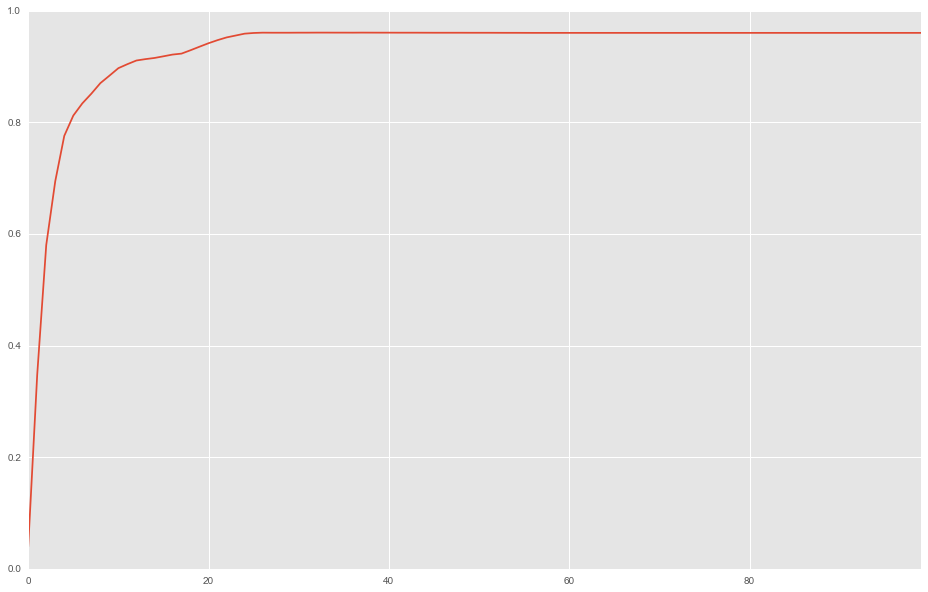

In [55]:
pd.Series(accuracy_score(y_test, y_test_hat > t) for t in list(np.arange(0.0, 1.0, .01))).plot()

In [62]:
ap = pd.DataFrame({
    'actual': y_test,
    'predictions': y_test_hat > 0.33
})

ap['incorrect'] = ap.actual == ap.predictions

In [70]:
ap.head()

,actual,predictions,incorrect
0,NaN,False,False
1,NaN,False,False
2,0.0,False,True
3,NaN,False,False
4,NaN,False,False


In [71]:
ap[ap.incorrect == True].actual.value_counts()

0.0    6164
Name: actual, dtype: int64

In [72]:
ap.actual.value_counts()

0.0    20519
1.0      845
Name: actual, dtype: int64

### AUROC

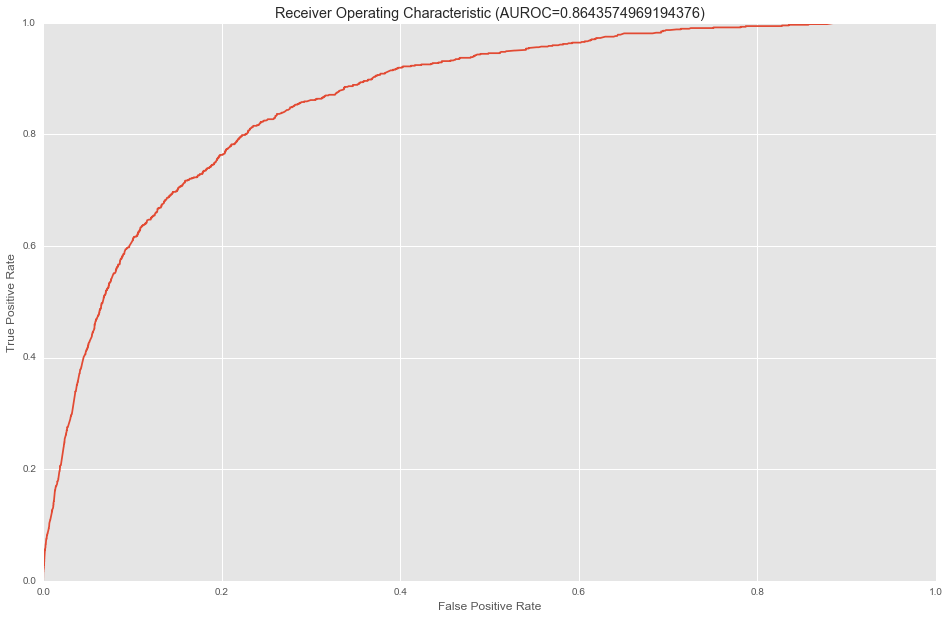

In [87]:
ml.plot_roc(y_test, y_test_hat)

## 7. Removed const cols in Test data

In [35]:
df = pd.read_csv(FILE_TRAIN_DEDUP_ONEHOT_NA_ONEHOTINT_1TEST)
df_test = pd.read_csv(FILE_TEST_DEDUP_ONEHOT_NA_ONEHOTINT_1TEST, index_col='ID')

# Split up the data
feature_cols = list(df.columns)
feature_cols.remove(TARGET_COL)
X_all = df[feature_cols]  # feature values for all students
y_all = df[TARGET_COL]

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

In [27]:
%%time

# GridCV for Gradient Boost Model
gbm = xgb.XGBRegressor(nthread=4, objective='binary:logistic')

param_grid = {
    'n_estimators': [129, 130, 131],
    'max_depth': [4],
    'learning_rate': [0.05],
}
best_score, best_model = ml.fine_tune_params(gbm,
                                             X_train, y_train,
                                             X_test, y_test,
                                             param_grid,
                                             n_runs=3,
                                             n_cv=5,
                                             scorer=roc_auc_score,
                                             n_jobs=1)

iteration 0
Each iteration time(secs): 205.560
iteration 1
Each iteration time(secs): 210.873
iteration 2
Each iteration time(secs): 218.712
CPU times: user 38min 55s, sys: 27.7 s, total: 39min 23s
Wall time: 10min 35s


In [29]:
print(" | ".join(map(str, (best_model.n_estimators,
                           best_model.max_depth,
                           best_model.learning_rate,
                           roc_auc_score(y_train, best_model.predict(X_train)),
                           best_score))))

130 | 4 | 0.05 | 0.864658233748 | 0.840711322253


n_estimators | max_depth | learning_rate | train score | test score | gridcv params
-------------|-----------|---------------|-------------|------------|-------------------------
200 | 4 | 0.05 | 0.872806025511 | 0.841855679438 | [100, 200, 300], [3, 4], [0.05],
175 | 4 | 0.05 | 0.870684656319 | 0.842048688602 | [175, 225], [3, 4], [0.05],
130 | 4 | 0.05 | 0.864658233748 | 0.840711322253 | [110, 120, 128, 130, 132, 150, 170, 175, 190], [4], [0.05],


In [36]:
gbm = xgb.XGBRegressor(max_depth=best_model.max_depth,
                       n_estimators=best_model.n_estimators,
                       learning_rate=best_model.learning_rate,
                       nthread=4, objective='binary:logistic')
kg.save_submission(gbm.fit(X_all, y_all).predict(df_test), 'submissions/const_test.xgb.csv')  # Score 0.837155

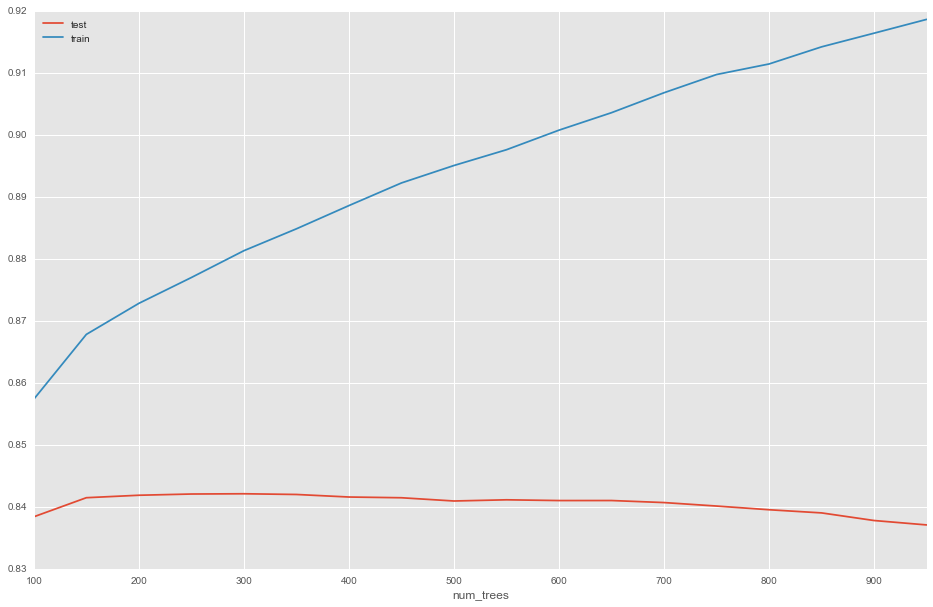

In [12]:
# Check performance over number of trees
train_scores = []
test_scores = []
num_trees_idx = list(range(100, 1000, 50))
for t in num_trees_idx:
    gbm = xgb.XGBRegressor(
        max_depth=4, n_estimators=t, learning_rate=0.05, nthread=8, objective='binary:logistic').fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, gbm.predict(X_train)))
    test_scores.append(roc_auc_score(y_test, gbm.predict(X_test)))
    
pd.DataFrame({
    'num_trees': num_trees_idx,
    'train': train_scores,
    'test': test_scores
}).set_index('num_trees').plot()

In [14]:
np.argmax(test_scores)

4

In [16]:
num_trees_idx[4]

300

## TensorFlow

In [3]:
# Read and split data
X_train, y_train, X_test, y_test, feature_cols, df_train, df_test = santander.read_split(santander.FILE_TRAIN,
                                                                                         santander.FILE_TEST)

In [ ]:
import tensorflow as tf
import math

num_steps = 1001
beta1 = 1e-5
beta2 = 1e-5
beta3 = 1e-5
batch_size = 128
H1 = 1024
H2 = 500
#IMAGE_PIXELS = image_size * image_size
n_features = len(feature_cols)
num_labels = 2
KEEP_PROB = 0.5
#learn_rate = 0.01
starter_learning_rate = 0.5

# Take small subset of training data
# _positions_small_subset = np.random.choice(train_dataset.shape[0], size=500, replace=False)
_train_data = train_dataset#[_positions_small_subset,:]
_train_y = train_labels#[_positions_small_subset, :]

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, n_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    keep_prob = tf.placeholder(tf.float32)
    
    # Hidden layer
    with tf.name_scope('hidden1') as scope:
        weights_hidden1 = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, H1],
                                stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))), name='weights1')
        biases_hidden1 = tf.Variable(tf.zeros([H1]), name='biases1')        
        hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden1) + biases_hidden1)

        # Dropout
#         hidden1 = tf.nn.dropout(hidden1, keep_prob)
        
    with tf.name_scope('hidden2') as scope:
        weights_hidden2 = tf.Variable(
            tf.truncated_normal([H1, H2],
                                stddev=1.0 / math.sqrt(float(H1))), name='weights2')
        biases_hidden2 = tf.Variable(tf.zeros([H2]), name='biases2')        
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights_hidden2) + biases_hidden2)

        # Dropout
#         hidden2 = tf.nn.dropout(hidden2, keep_prob)
        
    # Output
    with tf.name_scope('softmax_linear'):
        weights_out = tf.Variable(
            tf.truncated_normal([H2, num_labels],
                                stddev=1.0 / math.sqrt(float(H2))),
            name='weights')
        biases_out = tf.Variable(tf.zeros([num_labels]), name='biases_out')
        logits = tf.matmul(hidden2, weights_out) + biases_out

    # Training computation.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # L2 Regularization
    loss += (beta1 * tf.nn.l2_loss(weights_hidden1) + beta2 * tf.nn.l2_loss(weights_hidden2) + beta3 * tf.nn.l2_loss(weights_out))

    # Optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_prediction_after_h1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden1) + biases_hidden1)
    valid_prediction_after_h2 = tf.nn.relu(tf.matmul(valid_prediction_after_h1, weights_hidden2) + biases_hidden2)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction_after_h2, weights_out) + biases_out)

    test_prediction_after_h1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden1) + biases_hidden1)
    test_prediction_after_h2 = tf.nn.relu(tf.matmul(test_prediction_after_h1, weights_hidden2) + biases_hidden2)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_after_h2, weights_out) + biases_out)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):    
        _positions = np.random.choice(_train_data.shape[0], size=batch_size, replace=False)
        batch_data = _train_data[_positions, :]
        batch_labels = _train_y[_positions, :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: KEEP_PROB}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))